# Packages 

In [28]:
#install pyathena if needed
#!pip install pyathena
from pyathena import connect

In [19]:
import boto3
import sagemaker

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import seaborn as sns
from pathlib import Path

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set_style = "seaborn-whitegrid"

sns.set(
    rc={
        "font.style": "normal",
        "axes.facecolor": "white",
        "grid.color": ".8",
        "grid.linestyle": "-",
        "figure.facecolor": "white",
        "figure.titlesize": 20,
        "text.color": "black",
        "xtick.color": "black",
        "ytick.color": "black",
        "axes.labelcolor": "black",
        "axes.grid": True,
        "axes.labelsize": 10,
        "xtick.labelsize": 10,
        "font.size": 10,
        "ytick.labelsize": 10,
    }
)

# Set-up

In [10]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

# Load Athena Database for Merged Data

In [12]:
# Set Athena database & table
database_name = "ads508"
table_name = "merged_data"

In [13]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/ads508/athena/staging".format(bucket)

In [14]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [15]:
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head(5)

,database_name
0,ads508
1,default
2,dsoaws


# Download Merged Data from Public S3 Bucket

In [21]:
# Public Flight Data
s3_client = boto3.client("s3")

BUCKET='ads-508-airline'
KEY='merged/Dec_merged.csv'

response = s3_client.get_object(Bucket=BUCKET, Key=KEY)

pd.set_option('display.expand_frame_repr', False)
dec_merged = pd.read_csv(response.get("Body"))
dec_merged.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,DEST,DEP_DEL15,DEP_TIME_BLK,ARR_TIME_BLK,CANCELLED,CRS_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,MANUFACTURE_YEAR,NUMBER_OF_SEATS,AIRLINE_ID,CARRIER_NAME,PILOTS_COPILOTS,PASSENGER_HANDLING,PASS_GEN_SVC_ADMIN,MAINTENANCE,PRCP,SNOW,SNWD,TMAX,AWND
0,8,7,WN,N8651A,15016,STL,SAN,0.0,1100-1159,1300-1359,0.0,245.0,1557.0,7,0.0,0.0,18.0,0.0,0.0,2014.0,175.0,19393,Southwest Airlines Co.,8989.0,9668.0,15475.0,2482.0,0.02,0.0,0.0,58.0,9.84
1,8,7,WN,N939WN,15016,STL,SAT,0.0,1200-1259,1400-1459,0.0,145.0,786.0,4,NaN,NaN,NaN,NaN,NaN,2009.0,143.0,19393,Southwest Airlines Co.,8989.0,9668.0,15475.0,2482.0,0.02,0.0,0.0,58.0,9.84
2,8,7,WN,N7741C,15016,STL,SAT,0.0,2100-2159,0001-0559,0.0,140.0,786.0,4,NaN,NaN,NaN,NaN,NaN,2007.0,143.0,19393,Southwest Airlines Co.,8989.0,9668.0,15475.0,2482.0,0.02,0.0,0.0,58.0,9.84
3,8,7,WN,N550WN,15016,STL,SEA,0.0,0900-0959,1200-1259,0.0,275.0,1709.0,7,NaN,NaN,NaN,NaN,NaN,2001.0,143.0,19393,Southwest Airlines Co.,8989.0,9668.0,15475.0,2482.0,0.02,0.0,0.0,58.0,9.84
4,8,7,WN,N8319F,15016,STL,SFO,1.0,1800-1859,2000-2059,0.0,270.0,1735.0,7,NaN,NaN,NaN,NaN,NaN,2012.0,175.0,19393,Southwest Airlines Co.,8989.0,9668.0,15475.0,2482.0,0.02,0.0,0.0,58.0,9.84


In [30]:
dec_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619970 entries, 0 to 619969
Data columns (total 32 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   DAY_OF_MONTH         619970 non-null  int64  
 1   DAY_OF_WEEK          619970 non-null  int64  
 2   OP_UNIQUE_CARRIER    619970 non-null  object 
 3   TAIL_NUM             619970 non-null  object 
 4   ORIGIN_AIRPORT_ID    619970 non-null  int64  
 5   ORIGIN               619970 non-null  object 
 6   DEST                 619970 non-null  object 
 7   DEP_DEL15            619970 non-null  float64
 8   DEP_TIME_BLK         619970 non-null  object 
 9   ARR_TIME_BLK         619970 non-null  object 
 10  CANCELLED            619970 non-null  float64
 11  CRS_ELAPSED_TIME     619970 non-null  float64
 12  DISTANCE             619970 non-null  float64
 13  DISTANCE_GROUP       619970 non-null  int64  
 14  CARRIER_DELAY        126945 non-null  float64
 15  WEATHER_DELAY    

In [23]:
file_path = Path('../src/data/transformed_data/Dec_merged.csv')

if file_path.is_file():
    None
else:
    dec_merged.to_csv('../src/data/transformed_data/Dec_merged.csv', index=False)

# Set S3 Destination Location(Our S3 Private Bucket)

In [24]:
s3_private_path_csv = "s3://{}/ads508/data/merged".format(bucket)
print(s3_private_path_csv)

s3://sagemaker-us-east-1-229768475194/ads508/data/merged


In [25]:
%store s3_private_path_csv

Stored 's3_private_path_csv' (str)


# Copy Downloaded Local Data to our Private S3 Bucket in this Account

In [26]:
!aws s3 cp $file_path $s3_private_path_csv/ 

upload: ../src/data/transformed_data/Dec_merged.csv to s3://sagemaker-us-east-1-229768475194/ads508/data/merged/Dec_merged.csv


In [27]:
!aws s3 ls $s3_private_path_csv/

2022-03-25 00:01:51  102283704 Dec_merged.csv


# Create Table in Database

In [31]:
# SQL statement to execute
statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         DAY_OF_MONTH int,
         DAY_OF_WEEK int,
         OP_UNIQUE_CARRIER string,
         TAIL_NUM string,
         ORIGIN string,
         DEST string,
         DEP_DEL15 float,
         DEP_TIME_BLK string,
         ARR_TIME_BLK string,
         CANCELLED float,
         CRS_ELAPSED_TIME float,
         DISTANCE float,
         DISTANCE_GROUP int,
         CARRIER_DELAY float,
         WEATHER_DELAY float,
         NAS_DELAY float,
         SECURITY_DELAY float,
         LATE_AIRCRAFT_DELAY float,
         MANUFACTURE_YEAR float,
         NUMBER_OF_SEATS float, 
         AIRLINE_ID int, 
         CARRIER_NAME string,
         PILOTS_COPILOTS float,
         PASSENGER_HANDLING float,
         PASS_GEN_SVC_ADMIN float,
         MAINTENANCE float, 
         PRCP float,
         SNOW float,
         SNWD float,
         TMAX float,
         AWND float
         
     
         
        
) 
ROW FORMAT DELIMITED 
FIELDS TERMINATED BY ','
LINES TERMINATED BY '\n'
LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name, s3_private_path_csv
)

print(statement)

CREATE EXTERNAL TABLE IF NOT EXISTS ads508.merged_data(
         DAY_OF_MONTH int,
         DAY_OF_WEEK int,
         OP_UNIQUE_CARRIER string,
         TAIL_NUM string,
         ORIGIN string,
         DEST string,
         DEP_DEL15 float,
         DEP_TIME_BLK string,
         ARR_TIME_BLK string,
         CANCELLED float,
         CRS_ELAPSED_TIME float,
         DISTANCE float,
         DISTANCE_GROUP int,
         CARRIER_DELAY float,
         WEATHER_DELAY float,
         NAS_DELAY float,
         SECURITY_DELAY float,
         LATE_AIRCRAFT_DELAY float,
         MANUFACTURE_YEAR float,
         NUMBER_OF_SEATS float, 
         AIRLINE_ID int, 
         CARRIER_NAME string,
         PILOTS_COPILOTS float,
         PASSENGER_HANDLING float,
         PASS_GEN_SVC_ADMIN float,
         MAINTENANCE float, 
         PRCP float,
         SNOW float,
         SNWD float,
         TMAX float,
         AWND float
         
     
         
        
) 
ROW FORMAT DELIMITED 
FIELDS TERMINAT

In [19]:
# Droping table if needed
#statement2 = "DROP TABLE {}.{}".format(database_name, table_name)
#pd.read_sql(statement2, conn)

In [32]:
pd.read_sql(statement, conn)

""


# Verify the table has been created successfully

In [33]:
statement = "SHOW TABLES in {}".format(database_name)

df_show = pd.read_sql(statement, conn)
df_show.head(5)

,tab_name
0,flight_departure_delays
1,merged_data


# Run a sample query 

In [34]:
statement = """SELECT * FROM {}.{}
                LIMIT 10""".format(
    database_name, table_name
)

print(statement)

SELECT * FROM ads508.merged_data
                LIMIT 10


In [35]:
pd.read_sql(statement, conn)

,day_of_month,day_of_week,op_unique_carrier,tail_num,origin,dest,dep_del15,dep_time_blk,arr_time_blk,cancelled,crs_elapsed_time,distance,distance_group,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,manufacture_year,number_of_seats,airline_id,carrier_name,pilots_copilots,passenger_handling,pass_gen_svc_admin,maintenance,prcp,snow,snwd,tmax,awnd
0,5,4,AA,N159AN,13303,MIA,None,0.0,2000-2059,None,0.0,338.0,2267,10.0,NaN,NaN,NaN,NaN,NaN,2016.0,181,19805,None,8586.0,8586.0,15502.0,9677.0,0.00,0.0,0.0,73.0
1,6,5,AA,N902AA,13303,MIA,None,0.0,2000-2059,None,0.0,338.0,2267,10.0,NaN,NaN,NaN,NaN,NaN,2017.0,181,19805,None,8586.0,8586.0,15502.0,9677.0,0.00,0.0,0.0,79.0
2,7,6,AA,N149AN,13303,MIA,None,0.0,2000-2059,None,0.0,338.0,2267,10.0,NaN,NaN,NaN,NaN,NaN,2015.0,181,19805,None,8586.0,8586.0,15502.0,9677.0,0.00,0.0,0.0,82.0
3,8,7,AA,N996AN,13303,MIA,None,0.0,2000-2059,None,0.0,338.0,2267,10.0,NaN,NaN,NaN,NaN,NaN,2016.0,181,19805,None,8586.0,8586.0,15502.0,9677.0,0.00,0.0,0.0,82.0
4,9,1,AA,N150NN,13303,MIA,None,0.0,2000-2059,None,0.0,338.0,2267,10.0,NaN,NaN,NaN,NaN,NaN,2015.0,181,19805,None,8586.0,8586.0,15502.0,9677.0,0.01,0.0,0.0,83.0
5,10,2,AA,N143AN,13303,MIA,None,1.0,2000-2059,None,0.0,338.0,2267,10.0,NaN,NaN,NaN,NaN,NaN,2015.0,181,19805,None,8586.0,8586.0,15502.0,9677.0,0.00,0.0,0.0,84.0
6,11,3,AA,N160AN,13303,MIA,None,0.0,2000-2059,None,0.0,338.0,2267,10.0,NaN,NaN,NaN,NaN,NaN,2016.0,181,19805,None,8586.0,8586.0,15502.0,9677.0,0.47,0.0,0.0,85.0
7,12,4,AA,N998AN,13303,MIA,None,0.0,2000-2059,None,0.0,338.0,2267,10.0,NaN,NaN,NaN,NaN,NaN,2017.0,181,19805,None,8586.0,8586.0,15502.0,9677.0,0.46,0.0,0.0,82.0
8,13,5,AA,N149AN,13303,MIA,None,1.0,2000-2059,None,0.0,338.0,2267,10.0,17.0,0.0,0.0,0.0,0.0,2015.0,181,19805,None,8586.0,8586.0,15502.0,9677.0,0.01,0.0,0.0,82.0
9,14,6,AA,N905AU,13303,MIA,None,0.0,2000-2059,None,0.0,338.0,2267,10.0,NaN,NaN,NaN,NaN,NaN,2017.0,181,19805,None,8586.0,8586.0,15502.0,9677.0,0.00,0.0,0.0,87.0


# Review the New Athena Table in the Glue Catalog

In [24]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="top" href="https://console.aws.amazon.com/glue/home?region={}#">AWS Glue Catalog</a></b>'.format(
            region
        )
    )
)

# Explore Class Labels 

In [62]:
dec_merged.shape

(619970, 32)

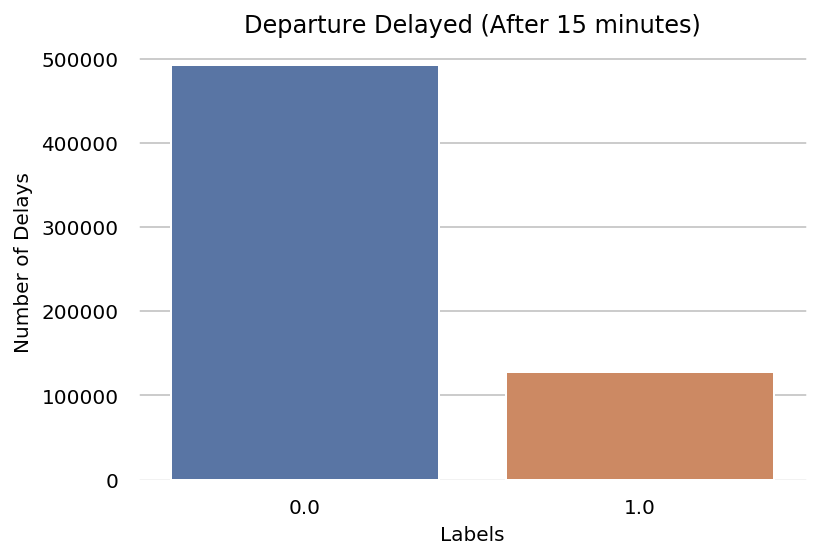

In [60]:
fig = sns.countplot(data=dec_merged, x="DEP_DEL15")
fig.set_xlabel("Labels")
fig.set_ylabel("Number of Delays")
fig.set_title("Departure Delayed (After 15 minutes)")
plt.show()

# Balance the Dataset by Departures 

In [68]:
df_grouped_by = dec_merged.groupby(["DEP_DEL15"])
df_balanced = df_grouped_by.apply(lambda x: x.sample(df_grouped_by.size().min()).reset_index(drop=True))
df_balanced.shape

(256012, 32)

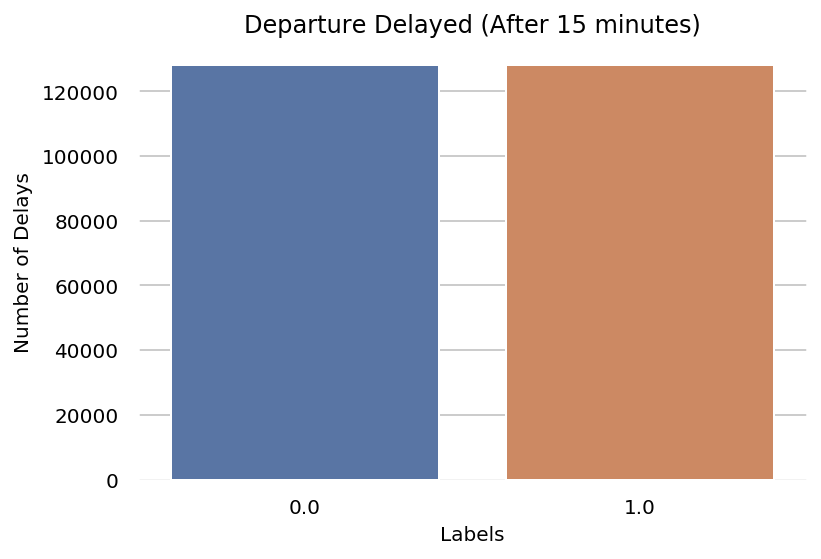

In [69]:
fig = sns.countplot(data=df_balanced, x="DEP_DEL15")
fig.set_xlabel("Labels")
fig.set_ylabel("Number of Delays")
fig.set_title("Departure Delayed (After 15 minutes)")
plt.show()

# Store Variables for the Next Notebooks

In [37]:
%store

Stored variables and their in-db values:
auto_ml_job_name                                      -> 'automl-dm-10-22-14-04'
autopilot_endpoint_arn                                -> 'arn:aws:sagemaker:us-east-1:229768475194:endpoint
autopilot_endpoint_name                               -> 'automl-dm-ep-10-22-58-33'
autopilot_model_arn                                   -> 'arn:aws:sagemaker:us-east-1:229768475194:model/au
autopilot_model_name                                  -> 'automl-dm-model-10-22-58-32'
autopilot_train_s3_uri                                -> 's3://sagemaker-us-east-1-229768475194/data/amazon
comprehend_train_s3_uri                               -> 's3://sagemaker-us-east-1-229768475194/data/amazon
ingest_create_athena_db_passed                        -> True
ingest_create_athena_table_parquet_passed             -> True
ingest_create_athena_table_tsv_passed                 -> True
s3_private_path_csv                                   -> 's3://sagemaker-us-east-1-229768

# Release Resources

In [38]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [39]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}

<IPython.core.display.Javascript object>